#### Optimum learning rate - Fixed for Python 3.11 and TensorFlow 2.x

In [1]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Input
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import utils
import tensorflow.keras as keras
import tensorflow as tf
# Use imageio.v2 to avoid deprecation warnings
import imageio.v2 as imageio
from PIL import Image
import math

2025-06-23 12:48:56.197058: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-23 12:48:56.205234: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-23 12:48:56.229798: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750663136.268358   18533 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750663136.283126   18533 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1750663136.314918   18533 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

In [2]:
# Reading the data
train = pd.read_csv('agedetectiontrain/train.csv')

# Image resizing of test data into single numpy array
temp = []
for img_name in train.ID:
    img_path = os.path.join('agedetectiontrain/Train', img_name)
    img = imageio.imread(img_path)
    img = np.array(Image.fromarray(img).resize((32, 32))).astype('float32')    
    temp.append(img)

train_x = np.stack(temp)

# Normalizing the images
train_x = train_x / 255.

# Encoding the categorical variable to numeric
lb = LabelEncoder()
train_y = lb.fit_transform(train.Class)
train_y = keras.utils.to_categorical(train_y)

In [3]:
# Specifying all the parameters we will be using in our network
input_num_units = (32, 32, 3)
hidden_num_units = 500
output_num_units = 3

epochs = 100
batch_size = 512

In [4]:
# Create model function for reusability
def create_model():
    model = keras.Sequential([
        keras.layers.Input(shape=input_num_units),
        keras.layers.Flatten(),
        keras.layers.Dense(hidden_num_units, activation='relu'),
        keras.layers.Dense(output_num_units, activation='softmax')
    ])
    return model

model = create_model()

2025-06-23 12:49:38.115378: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [5]:
# Defining parameters like optimizer, loss function and evaluating metric
model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy'])

In [6]:
# Simplified Learning Rate Finder
class SimpleLRFinder:
    def __init__(self, model):
        self.model = model
        self.lrs = []
        self.losses = []
        
    def find_lr(self, X, y, start_lr=1e-7, end_lr=10, num_it=100, beta=0.98):
        # Save original weights
        original_weights = self.model.get_weights()
        
        # Initialize
        self.lrs = []
        self.losses = []
        
        # Learning rate multiplier
        mult = (end_lr / start_lr) ** (1/num_it)
        lr = start_lr
        
        # Create a copy of the model for lr finding
        temp_model = create_model()
        temp_model.compile(loss='categorical_crossentropy',
                          optimizer=keras.optimizers.Adam(learning_rate=lr),
                          metrics=['accuracy'])
        
        # Variables for smoothing
        avg_loss = 0
        best_loss = 0
        
        # Randomly select indices for training
        indices = np.random.choice(len(X), size=num_it * 32, replace=True)
        
        print(f"Finding learning rate from {start_lr} to {end_lr}...")
        
        for i in range(num_it):
            # Get batch
            batch_indices = indices[i*32:(i+1)*32]
            batch_x = X[batch_indices]
            batch_y = y[batch_indices]
            
            # Update learning rate
            temp_model.optimizer.learning_rate.assign(lr)
            
            # Train on batch
            with tf.GradientTape() as tape:
                predictions = temp_model(batch_x, training=True)
                loss = temp_model.compiled_loss(batch_y, predictions)
            
            # Get gradients and apply
            gradients = tape.gradient(loss, temp_model.trainable_variables)
            temp_model.optimizer.apply_gradients(zip(gradients, temp_model.trainable_variables))
            
            # Convert loss to numpy
            loss_val = float(loss.numpy())
            
            # Smooth the loss
            if i == 0:
                avg_loss = loss_val
            else:
                avg_loss = beta * avg_loss + (1 - beta) * loss_val
            
            smoothed_loss = avg_loss / (1 - beta ** (i + 1))
            
            # Record
            self.lrs.append(lr)
            self.losses.append(smoothed_loss)
            
            # Check if loss is exploding
            if i > 0 and smoothed_loss > 4 * best_loss:
                print(f"Stopping early at iteration {i} due to loss explosion")
                break
                
            # Update best loss
            if smoothed_loss < best_loss or i == 0:
                best_loss = smoothed_loss
            
            # Update learning rate
            lr *= mult
            
            if i % 10 == 0:
                print(f"Iteration {i}, LR: {self.lrs[-1]:.2e}, Loss: {smoothed_loss:.4f}")
        
        # Restore original model weights
        self.model.set_weights(original_weights)
        print("Learning rate finder completed!")
        
    def plot(self, skip_start=10, skip_end=5):
        if len(self.lrs) == 0:
            print("No data to plot. Run find_lr first.")
            return
            
        # Skip some points
        lrs = self.lrs[skip_start:len(self.lrs)-skip_end] if skip_end > 0 else self.lrs[skip_start:]
        losses = self.losses[skip_start:len(self.losses)-skip_end] if skip_end > 0 else self.losses[skip_start:]
        
        plt.figure(figsize=(10, 6))
        plt.plot(lrs, losses)
        plt.xscale('log')
        plt.xlabel('Learning Rate')
        plt.ylabel('Loss')
        plt.title('Learning Rate vs Loss')
        plt.grid(True)
        plt.show()
        
        # Find optimal learning rate (steepest descent)
        try:
            gradients = np.gradient(losses)
            min_gradient_idx = np.argmin(gradients)
            optimal_lr = lrs[min_gradient_idx]
            print(f"Suggested learning rate: {optimal_lr:.2e}")
            return optimal_lr
        except:
            print("Could not determine optimal learning rate")
            return None

In [7]:
# Use the learning rate finder
lr_finder = SimpleLRFinder(model)
lr_finder.find_lr(train_x, train_y, start_lr=1e-6, end_lr=1e-1, num_it=100)

Finding learning rate from 1e-06 to 0.1...


/home/wolf/anaconda3/envs/deepl-env/lib/python3.11/site-packages/keras/src/backend/tensorflow/trainer.py:671: UserWarning: `model.compiled_loss()` is deprecated. Instead, use `model.compute_loss(x, y, y_pred, sample_weight, training)`.
  warnings.warn(


Iteration 0, LR: 1.00e-06, Loss: 48.8988
Iteration 10, LR: 3.16e-06, Loss: 4.9462
Iteration 20, LR: 1.00e-05, Loss: 2.8335
Iteration 30, LR: 3.16e-05, Loss: 2.1090
Iteration 40, LR: 1.00e-04, Loss: 1.7288
Iteration 50, LR: 3.16e-04, Loss: 1.4999
Iteration 60, LR: 1.00e-03, Loss: 1.3581
Iteration 70, LR: 3.16e-03, Loss: 1.3758
Iteration 80, LR: 1.00e-02, Loss: 1.3086
Iteration 90, LR: 3.16e-02, Loss: 1.2321
Learning rate finder completed!


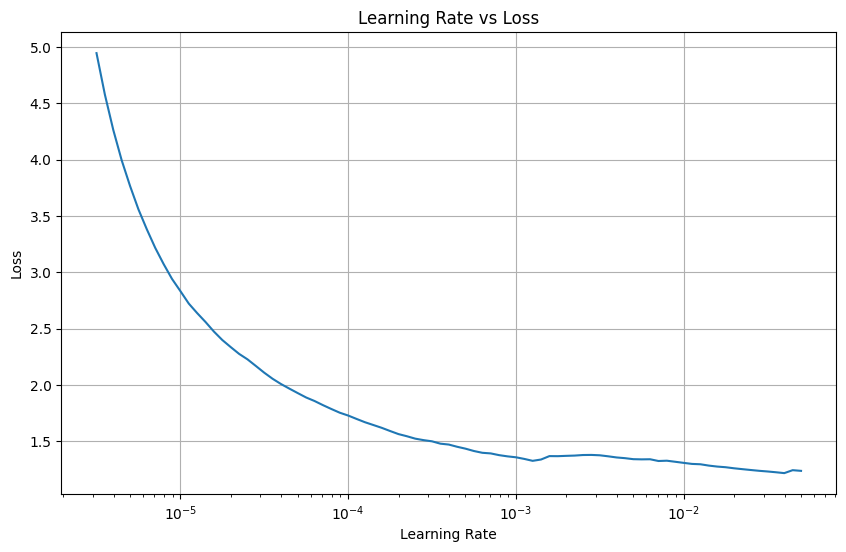

Suggested learning rate: 3.16e-06


In [8]:
# Plot the results
optimal_lr = lr_finder.plot(skip_start=10, skip_end=5)

#### From the above figure, choose appropriate learning rates:
* base_lr = $10^{-4}$ (or use the suggested optimal learning rate divided by 10)
* max_lr = $10^{-3}$ (or use the suggested optimal learning rate)

## Setting cyclic learning rate for model training

In [9]:
# Simplified Cyclic Learning Rate Callback
class CyclicLR(keras.callbacks.Callback):
    def __init__(self, base_lr=0.001, max_lr=0.006, step_size=2000, mode='triangular2'):
        super(CyclicLR, self).__init__()
        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        self.mode = mode
        self.clr_iterations = 0
        self.trn_iterations = 0
        self.history = {'lr': [], 'iterations': []}

    def clr(self):
        cycle = np.floor(1 + self.clr_iterations / (2 * self.step_size))
        x = np.abs(self.clr_iterations / self.step_size - 2 * cycle + 1)
        
        if self.mode == 'triangular':
            scale_factor = 1.0
        elif self.mode == 'triangular2':
            scale_factor = 1 / (2.0 ** (cycle - 1))
        else:
            scale_factor = 1.0
            
        return self.base_lr + (self.max_lr - self.base_lr) * np.maximum(0, (1 - x)) * scale_factor

    def on_train_begin(self, logs=None):
        self.model.optimizer.learning_rate.assign(self.base_lr)

    def on_batch_end(self, batch, logs=None):
        self.trn_iterations += 1
        self.clr_iterations += 1
        
        # Record current learning rate
        current_lr = float(self.model.optimizer.learning_rate.numpy())
        self.history['lr'].append(current_lr)
        self.history['iterations'].append(self.trn_iterations)
        
        # Set new learning rate
        new_lr = self.clr()
        self.model.optimizer.learning_rate.assign(new_lr)

In [10]:
# Create a fresh model for training
model = create_model()
model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy'])

# Set up callbacks
cb_triangular = CyclicLR(base_lr=0.0001, max_lr=0.001, step_size=2000, mode='triangular2')
cb_save = keras.callbacks.TensorBoard(log_dir='learning_rate', write_graph=False)

In [11]:
# Train the model
print("Starting model training...")
history = model.fit(train_x, train_y, 
                   batch_size=batch_size, 
                   epochs=epochs, 
                   validation_split=0.2, 
                   callbacks=[cb_triangular, cb_save], 
                   verbose=1)
print('Model training completed successfully!')

Starting model training...
Epoch 1/100


2025-06-23 12:49:48.782222: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 195674112 exceeds 10% of free system memory.


32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 86ms/step - accuracy: 0.5433 - loss: 0.9709 - val_accuracy: 0.6022 - val_loss: 0.8637
Epoch 2/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 82ms/step - accuracy: 0.6063 - loss: 0.8541 - val_accuracy: 0.6193 - val_loss: 0.8302
Epoch 3/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - accuracy: 0.6177 - loss: 0.8325 - val_accuracy: 0.6296 - val_loss: 0.8189
Epoch 4/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step - accuracy: 0.6218 - loss: 0.8179 - val_accuracy: 0.6369 - val_loss: 0.7985
Epoch 5/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - accuracy: 0.6349 - loss: 0.7968 - val_accuracy: 0.5768 - val_loss: 0.8897
Epoch 6/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step - accuracy: 0.6213 - loss: 0.8141 - val_accuracy: 0.6524 - val_loss: 0.7861
Epoch 7/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - accuracy: 0.6461 - loss: 0.7884 - val_accuracy: 0.6017 - val_loss: 0.8442
Epoch 8/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step - accuracy: 0.6433 - loss: 0.7883 - val_accuracy: 0.6527 - val_l

KeyboardInterrupt: 

In [ ]:
# Plot the cyclic learning rate
plt.figure(figsize=(12, 8))

# Plot learning rate schedule
plt.subplot(2, 2, 1)
plt.plot(cb_triangular.history['iterations'], cb_triangular.history['lr'])
plt.xlabel('Training Iterations')
plt.ylabel('Learning Rate')
plt.title("CLR - 'triangular2' Policy")
plt.grid(True)

# Plot training loss
plt.subplot(2, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot training accuracy
plt.subplot(2, 2, 3)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot learning rate vs loss
plt.subplot(2, 2, 4)
plt.plot(cb_triangular.history['lr'][:len(history.history['loss'])], history.history['loss'])
plt.xlabel('Learning Rate')
plt.ylabel('Training Loss')
plt.title('Learning Rate vs Training Loss')
plt.grid(True)

plt.tight_layout()
plt.show()

print(f"Final training accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"Final validation accuracy: {history.history['val_accuracy'][-1]:.4f}")